# Используемые библиотеки

In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, BatchNormalization
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MSE
import matplotlib.pyplot as plt
%matplotlib inline

# Загрузка и подготовка данных

In [2]:
# загружаем данные MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


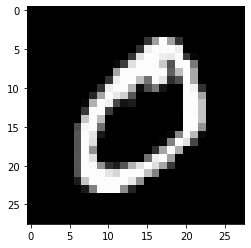

In [13]:
# посмотри на то, что загрузили в виде картинки
plt.imshow(x_train[1], cmap='gray')
plt.show()

In [14]:
# а теперь в виде массива
for line in x_train[1]:
  print(' '.join(['{0: <3}'.format(i) for i in line.astype('str')]))

0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   51  159 253 159 50  0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0   0   0   48  238 252 252 252 237 0   0   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   0   0   54  227 253 252 239 233 252 57  6   0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   10  60  224 252 253 252 202 84  252 253 122 0   0   0   0   0   0  
0   0   0   0   0   0   0   0   0   0   0   163 252 252 252 253 252 252 96  189 253 167 0   0   0   0   

In [9]:
# узнаем размеры данных
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape  =', x_test.shape)
print('y_test.shape  =', y_test.shape)

x_train.shape = (60000, 28, 28)
y_train.shape = (60000,)
x_test.shape  = (10000, 28, 28)
y_test.shape  = (10000,)


In [10]:
y_train[600]

9

In [15]:
# нормируем и приведем к требуему формату данные
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

In [16]:
# отдельно выделим нули как нормальное для нас состояние
x_train_zeros = x_train[y_train == 0]
x_test_zeros = x_test[y_test == 0]
print('x_train_zeros.shape =', x_train_zeros.shape)
print('x_test_zeros.shape  =', x_test_zeros.shape)

x_train_zeros.shape = (5923, 28, 28, 1)
x_test_zeros.shape  = (980, 28, 28, 1)


In [17]:
# единицы и двойки будут известными нам аномалиями
x_train_ones = x_train[y_train == 1]
x_test_ones = x_test[y_test == 1]
x_train_twos = x_train[y_train == 2]
x_test_twos = x_test[y_test == 2]
print('x_train_ones.shape =', x_train_ones.shape)
print('x_test_ones.shape  =', x_test_ones.shape)
print('x_train_twos.shape =', x_train_twos.shape)
print('x_test_twos.shape  =', x_test_twos.shape)

x_train_ones.shape = (6742, 28, 28, 1)
x_test_ones.shape  = (1135, 28, 28, 1)
x_train_twos.shape = (5958, 28, 28, 1)
x_test_twos.shape  = (1032, 28, 28, 1)


In [18]:
# тройки сыграют роль неизвестных аномалий
x_train_triples = x_train[y_train == 3]
x_test_triples = x_test[y_test == 3]
print('x_train_zeros.shape =', x_train_triples.shape)
print('x_test_zeros.shape  =', x_test_triples.shape)

x_train_zeros.shape = (6131, 28, 28, 1)
x_test_zeros.shape  = (1010, 28, 28, 1)


In [19]:
# собирем датасет аномалий
x_train_anomaly = np.concatenate([x_train_ones,
                                  x_train_twos,
                                  x_train_triples], axis=0)
x_test_anomaly = np.concatenate([x_test_ones,
                                 x_test_twos,
                                 x_test_triples], axis=0)
y_train_anomaly = np.concatenate([np.full((x_train_ones.shape[0], 3),    [0., 1., 0.]),
                                  np.full((x_train_twos.shape[0], 3),    [0., 0., 1.]),
                                  np.full((x_train_triples.shape[0], 3), [1., 0., 0.])], axis=0)
y_test_anomaly = np.concatenate([np.full((x_test_ones.shape[0], 3),    [0., 1., 0.]),
                                 np.full((x_test_twos.shape[0], 3),    [0., 0., 1.]),
                                 np.full((x_test_triples.shape[0], 3), [1., 0., 0.])], axis=0)
print('x_train_anomaly.shape =', x_train_anomaly.shape)
print('y_train_anomaly.shape =', y_train_anomaly.shape)
print('x_test_anomaly.shape  =', x_test_anomaly.shape)
print('y_test_anomaly.shape  =', y_test_anomaly.shape)

x_train_anomaly.shape = (18831, 28, 28, 1)
y_train_anomaly.shape = (18831, 3)
x_test_anomaly.shape  = (3177, 28, 28, 1)
y_test_anomaly.shape  = (3177, 3)


# Автокодировщик

In [21]:
# создаем энкодер
enc_in = Input(shape=(28, 28, 1))
enc_x = Flatten()(enc_in)
enc_x = Dense(800, activation='sigmoid')(enc_x)
enc_x = BatchNormalization()(enc_x)
enc_x = Dense(400, activation='sigmoid')(enc_x)
enc_x = BatchNormalization()(enc_x)
enc_x = Dense(200, activation='sigmoid')(enc_x)
enc_x = BatchNormalization()(enc_x)
enc_x = Dense(50, activation='relu')(enc_x)
enc_model = Model(enc_in, enc_x)
print(enc_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 800)               628000    
                                                                 
 batch_normalization_3 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 400)               320400    
                                                                 
 batch_normalization_4 (Batc  (None, 400)              1600      
 hNormalization)                                           

In [22]:
# создаем декондер
dec_in = Input(shape=(50,))
dec_x = Dense(200, activation='sigmoid')(dec_in)
dec_x = BatchNormalization()(dec_x)
dec_x = Dense(400, activation='sigmoid')(dec_x)
dec_x = BatchNormalization()(dec_x)
dec_x = Dense(784, activation='relu')(dec_x)
dec_x = Reshape((28, 28, 1))(dec_x)
dec_model = Model(dec_in, dec_x)
print(dec_model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_8 (Dense)             (None, 200)               10200     
                                                                 
 batch_normalization_6 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 400)               80400     
                                                                 
 batch_normalization_7 (Batc  (None, 400)              1600      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 784)               3143

In [23]:
# создаем автокодировщик
ae_model = Model(enc_in, dec_model(enc_model(enc_in)))
print(ae_model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_1 (Functional)        (None, 50)                1044250   
                                                                 
 model_2 (Functional)        (None, 28, 28, 1)         407384    
                                                                 
Total params: 1,451,634
Trainable params: 1,447,634
Non-trainable params: 4,000
_________________________________________________________________
None


In [24]:
# компилируем
ae_model.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
# callback
m_ch = ModelCheckpoint(
        'ae_1.h5',
        monitor = "val_accuracy",
        verbose = 1,
        save_best_only = True,
        save_weights_only = True,
        mode = "max",
        save_freq="epoch")

In [26]:
# обучаем
history = ae_model.fit(
    x_train_zeros,
    x_train_zeros,
    batch_size=128,
    epochs=500,
    verbose=1,
    validation_split=0.2,
    shuffle=True,
    callbacks=[m_ch]
)

Epoch 1/500
32/38 [========================>.....] - ETA: 0s - loss: 0.2319 - accuracy: 0.6202
Epoch 1: val_accuracy improved from -inf to 0.70577, saving model to ae_1.h5
38/38 [==============================] - 4s 16ms/step - loss: 0.2182 - accuracy: 0.6310 - val_loss: 0.1573 - val_accuracy: 0.7058
Epoch 2/500
34/38 [=========================>....] - ETA: 0s - loss: 0.0957 - accuracy: 0.7389
Epoch 2: val_accuracy improved from 0.70577 to 0.73042, saving model to ae_1.h5
38/38 [==============================] - 0s 10ms/step - loss: 0.0943 - accuracy: 0.7400 - val_loss: 0.1458 - val_accuracy: 0.7304
Epoch 3/500
32/38 [========================>.....] - ETA: 0s - loss: 0.0735 - accuracy: 0.7517
Epoch 3: val_accuracy improved from 0.73042 to 0.74642, saving model to ae_1.h5
38/38 [==============================] - 0s 9ms/step - loss: 0.0730 - accuracy: 0.7518 - val_loss: 0.1389 - val_accuracy: 0.7464
Epoch 4/500
33/38 [=========================>....] - ETA: 0s - loss: 0.0665 - accuracy: 0

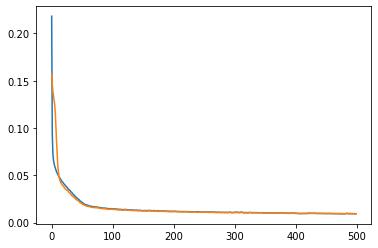

In [27]:
# Посмотрим на результат обучения
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

In [28]:
# загружаем лучшие веса
ae_model.load_weights('ae_1.h5')

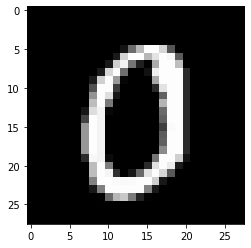

In [31]:
# оценка работы
# входящие данные
input_image = x_test_zeros[256:257]
plt.imshow(input_image[0,:,:,0], cmap='gray')
plt.show()

1/1 [==============================] - 0s 16ms/step


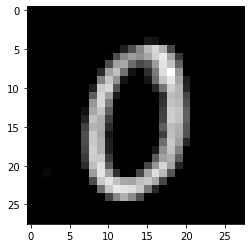

In [32]:
# оценка работы
# результат
result_image = ae_model.predict(input_image)
plt.imshow(result_image[0,:,:,0], cmap='gray')
plt.show()

# Фильтруем аномалии

In [33]:
mse_zeros = []
for input_img in x_test_zeros[:100]:
  input_img = input_img[np.newaxis,:,:,:]
  result_img = ae_model.predict(input_img, verbose=0)
  mse_zeros.append(np.array(MSE(input_img, result_img)).mean())

print('mean:', sum(mse_zeros)/len(mse_zeros))
print('max:', max(mse_zeros))
print('min:', min(mse_zeros))

mean: 0.00876257331809029
max: 0.03190107
min: 0.0026312463


In [34]:
mse_ones = []
for input_img in x_test_ones[:100]:
  input_img = input_img[np.newaxis,:,:,:]
  result_img = ae_model.predict(input_img, verbose=0)
  mse_ones.append(np.array(MSE(input_img, result_img)).mean())

print('mean:', sum(mse_ones)/len(mse_ones))
print('max:', max(mse_ones))
print('min:', min(mse_ones))

mean: 0.02226621565409005
max: 0.041470353
min: 0.010061503


In [35]:
mse_twos = []
for input_img in x_test_twos[:100]:
  input_img = input_img[np.newaxis,:,:,:]
  result_img = ae_model.predict(input_img, verbose=0)
  mse_twos.append(np.array(MSE(input_img, result_img)).mean())

print('mean:', sum(mse_twos)/len(mse_twos))
print('max:', max(mse_twos))
print('min:', min(mse_twos))

mean: 0.03505844255909324
max: 0.06299304
min: 0.017491452


In [36]:
enc_model(x_test_zeros[99:100])

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[1.6124352 , 0.        , 0.36126384, 1.3992975 , 0.        ,
        2.062515  , 1.6741095 , 2.6995623 , 0.        , 1.1761317 ,
        0.        , 0.        , 0.3150459 , 0.        , 0.        ,
        0.6888032 , 0.6398982 , 0.72299266, 4.1705003 , 1.3493075 ,
        0.        , 3.7007751 , 0.18760765, 3.6752024 , 2.6366236 ,
        0.53830194, 1.5410465 , 0.03987119, 3.3057704 , 0.        ,
        0.66135216, 0.        , 1.3037457 , 3.545833  , 0.        ,
        0.        , 1.3616806 , 0.        , 1.5445292 , 1.2123315 ,
        2.3004985 , 0.        , 0.8504998 , 2.4197624 , 2.2473469 ,
        0.        , 1.4239012 , 0.4326233 , 2.5409646 , 0.        ]],
      dtype=float32)>

In [37]:
enc_model(x_test_twos[99:100])

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[1.8126299e+00, 1.2337023e+00, 9.2309177e-01, 2.4523025e+00,
        2.2468880e-01, 2.0291800e+00, 3.4475701e+00, 7.0051968e-01,
        5.0516021e-01, 1.4906393e+00, 0.0000000e+00, 1.4908090e+00,
        0.0000000e+00, 1.5442739e-01, 6.8024772e-01, 3.9368639e+00,
        2.6823297e+00, 3.3981540e+00, 0.0000000e+00, 0.0000000e+00,
        1.2643209e+00, 2.7996700e+00, 1.6582061e+00, 0.0000000e+00,
        0.0000000e+00, 2.7694702e-03, 0.0000000e+00, 1.2338450e+00,
        2.1814725e+00, 2.7800446e+00, 4.0296493e+00, 0.0000000e+00,
        1.1268330e+00, 2.2606208e+00, 0.0000000e+00, 2.3288124e+00,
        2.6364636e+00, 4.0519729e-01, 8.5500193e-01, 1.7742583e-01,
        2.7565119e-01, 0.0000000e+00, 1.1188662e+00, 0.0000000e+00,
        1.5530434e+00, 2.0944140e+00, 3.6653233e-01, 8.9968157e-01,
        1.7754594e+00, 0.0000000e+00]], dtype=float32)>